In [66]:
#Import libraries and dependencies
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(32)
import get_model_portfolio_tickers as gmpt
import get_model_portfolio_weights as gmpw
import hvplot.pandas
import seaborn as sns

In [77]:
ticker = gmpt.get_model_portfolio_tickers('fixed_income')
weights = gmpw.get_model_portfolio_weights('fixed_income')

In [78]:
ticker

['BSV', 'BIV', 'BLV', 'VMBS', 'BNDX', 'FLRN']

In [79]:
weights


[0.267, 0.138, 0.129, 0.152, 0.294, 0.02]

In [81]:
end_date = datetime.now()
start_date = end_date + timedelta(-1825)

# Get 5 year's worth of historical data for AAPL
df = get_historical_data(ticker, start_date, end_date,  output_format='pandas')
df.tail()

IEXQueryError: An error occurred while making the query.

In [71]:
 # Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level = 1, inplace=True)
df.head()

,VOO,VXF,VEA,VWO,BSV,BIV,BLV,VMBS,BNDX,FLRN
,close,close,close,close,close,close,close,close,close,close
date,,,,,,,,,,
2014-09-23,181.53,84.55,40.59,43.04,80.05,84.16,89.95,52.52,52.03,30.66
2014-09-24,182.99,85.14,40.60,43.26,80.04,83.99,89.54,52.44,52.00,30.65
2014-09-25,180.05,83.93,40.03,42.26,80.09,84.27,90.27,52.57,52.13,30.69
2014-09-26,181.50,84.59,40.18,42.53,80.05,84.12,90.17,52.48,52.08,30.65
2014-09-29,181.14,84.44,39.83,41.62,80.07,84.21,90.28,52.59,52.11,30.65


In [72]:
df = df.droplevel(1, axis = 1)

In [73]:
df

,VOO,VXF,VEA,VWO,BSV,BIV,BLV,VMBS,BNDX,FLRN
date,,,,,,,,,,
2014-09-23,181.53,84.55,40.59,43.04,80.05,84.16,89.95,52.52,52.03,30.66
2014-09-24,182.99,85.14,40.60,43.26,80.04,83.99,89.54,52.44,52.00,30.65
2014-09-25,180.05,83.93,40.03,42.26,80.09,84.27,90.27,52.57,52.13,30.69
2014-09-26,181.50,84.59,40.18,42.53,80.05,84.12,90.17,52.48,52.08,30.65
2014-09-29,181.14,84.44,39.83,41.62,80.07,84.21,90.28,52.59,52.11,30.65
...,...,...,...,...,...,...,...,...,...,...
2019-09-16,275.67,119.51,41.47,41.85,80.50,87.02,99.80,53.07,58.32,30.73
2019-09-17,276.42,119.58,41.63,41.90,80.56,87.19,100.33,53.06,58.36,30.71
2019-09-18,276.59,119.08,41.52,41.69,80.57,87.27,100.73,53.11,58.55,30.72


In [74]:
daily_rteurns = df.pct_change().copy()
means = daily_rteurns.mean()
stds = daily_rteurns.std()
variances = daily_rteurns.var()
current_pirces = pd.DataFrame(df.iloc[-1])
current_pirces = current_pirces.transpose()
monte_carlo_cum_ret = pd.DataFrame()
    
       
    
    
for n in range(1000):

    #sets prices as current prices
    prices = current_pirces


    #Repeats simulation for "sim_days" times
    for i in range(252):

        #creates an empty dict to store simulated prices
        #of every ticker of a single day
        simulated_prices = {}


        #loops through every ticker last price availabe
        for stock,price in prices.iloc[-1].items():

            #sets a new random price assuming a normal distribution with the 
            #avarage and standard deviation obtained from prices dataframe 
            #new_price = price * (1 + np.random.normal(means[stock],stds[stock])) #old monte -carlo
            daily_drift = means[stock] - (variances[stock]/2)
            drift = daily_drift - 0.5 * stds[stock] ** 2
            diffusion = stds[stock] * np.random.laplace()
            new_price = price * np.exp(drift + diffusion)

            #Adds the key, value pair of the ticker with the new price simulated
            #to the simulated_prices dict.
            simulated_prices.update({stock : [new_price]})


        #Converts the dict to a dataframe to stack it up and build up 
        #the monte-carlo dataframe of a single simulation of "sim_days" days
        new_sim_prices_df = pd.DataFrame.from_dict(simulated_prices)
        prices = pd.concat([prices,new_sim_prices_df],axis = 0,ignore_index=True)
            
            

    #converts the dataframe of simulated prices into a daily return df
    simulated_daily_returns = prices.pct_change()

    #converts the portfolio of daily returns of different stocks into a
    #single-column dataframe of the total returns per day after applying weihgts
    portfolio_daily_returns = simulated_daily_returns.dot(weights)

    #stacks horizontally the single simulation result to build the final monte-carlo
    #dataframe after the "trials" trials.
    monte_carlo_cum_ret[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
        



    

In [75]:
monte_carlo_cum_ret.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999906,1.000192,0.998322,0.999176,0.999230,1.003081,1.000368,0.999628,0.998917,1.001386,...,0.999845,0.999463,0.999827,1.000154,1.000186,1.001029,1.000907,1.002467,0.998398,0.998442
2,1.002747,1.006001,0.996969,0.995549,0.999849,1.003380,1.000627,0.996408,0.999278,1.002563,...,1.000931,0.998324,1.001817,1.000663,0.997769,1.002470,1.001871,0.997784,0.993443,0.998074
3,1.001444,1.006933,0.994929,0.994110,1.000223,1.004616,1.000949,0.996490,0.998837,1.000987,...,1.001452,0.998555,1.000201,0.998036,0.998375,1.002681,1.002642,0.996365,0.991718,1.000492
4,1.003108,1.005965,0.992836,0.993802,1.002349,1.006126,1.000234,0.994478,0.999598,0.999277,...,1.000851,0.999052,0.998074,0.998020,0.998591,1.003388,1.006079,0.995251,0.987437,1.000126


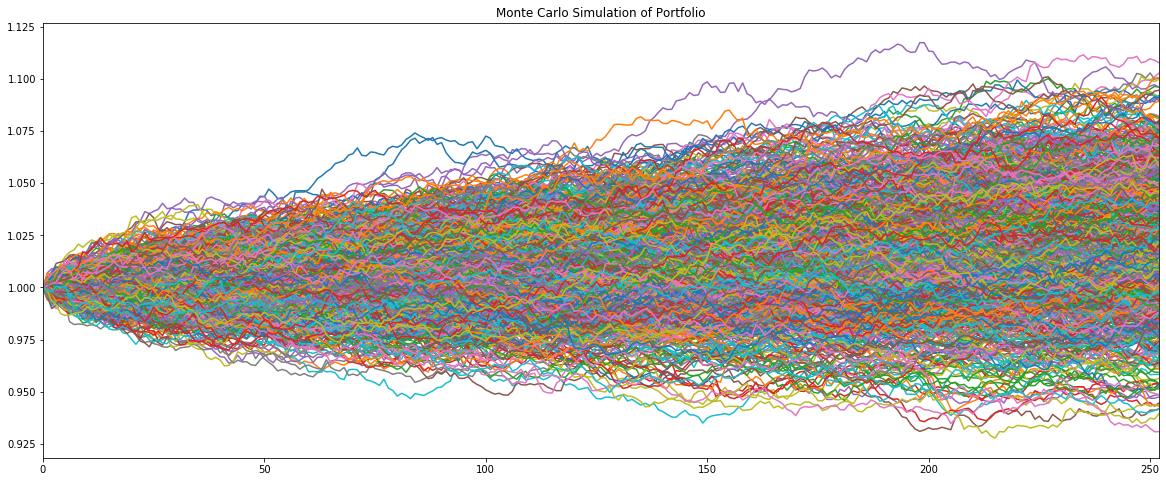

In [76]:

plot_title = f"Monte Carlo Simulation of Portfolio"
monte_carlo_sim_plot = monte_carlo_cum_ret.plot(title=plot_title,figsize=(20,8),legend=False)
monte_carlo_sim_plot


In [36]:
hist_daily_returns_df = daily_rteurns.dropna()
hist_daily_returns_df.to_csv("conservative_hist_daily_returns.csv")


,VOO,VXF,VEA,VWO,BSV,BIV,BLV,VMBS,BNDX,FLRN
date,,,,,,,,,,
2014-09-24,0.008043,0.006978,0.000246,0.005112,-0.000125,-0.002020,-0.004558,-0.001523,-0.000577,-0.000326
2014-09-25,-0.016066,-0.014212,-0.014039,-0.023116,0.000625,0.003334,0.008153,0.002479,0.002500,0.001305
2014-09-26,0.008053,0.007864,0.003747,0.006389,-0.000499,-0.001780,-0.001108,-0.001712,-0.000959,-0.001303
2014-09-29,-0.001983,-0.001773,-0.008711,-0.021397,0.000250,0.001070,0.001220,0.002096,0.000576,0.000000
2014-09-30,-0.003036,-0.010185,-0.002009,0.002162,0.000000,0.000594,-0.000554,-0.000380,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2019-09-16,-0.003290,0.000921,-0.007182,-0.008059,0.001368,0.003459,0.008896,0.002077,0.002751,0.000000
2019-09-17,0.002721,0.000586,0.003858,0.001195,0.000745,0.001954,0.005311,-0.000188,0.000686,-0.000651
2019-09-18,0.000615,-0.004181,-0.002642,-0.005012,0.000124,0.000918,0.003987,0.000942,0.003256,0.000326


In [40]:
monte_carlo_cum_ret.to_csv("conservative_simulated_cumulative_returns.csv")

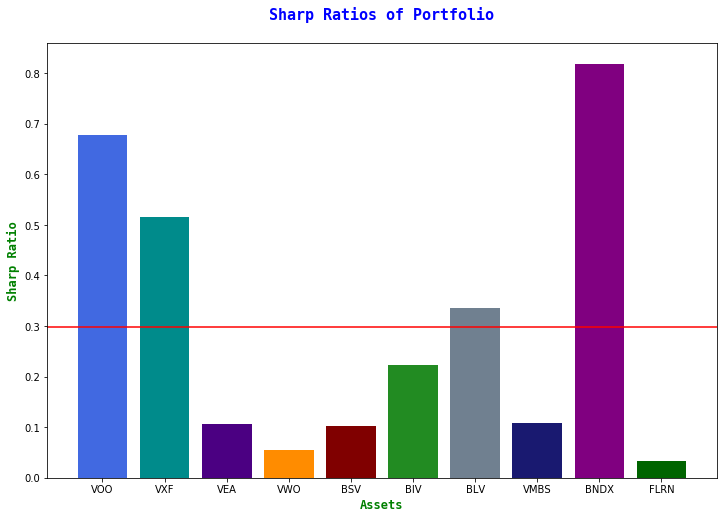

In [42]:

    
title_font = {'family': 'monospace',
        'color':  'blue',
        'weight': 'bold',
        'size': 15,
        }
label_font = {'family': 'monospace',
        'color':  'green',
        'weight': 'bold',
        'size': 12,
        }
   
bar_colors=["midnightblue","royalblue","indigo","darkcyan","darkgreen","maroon",
            "purple","darkorange","slategray","forestgreen"]

sharp_ratios = daily_rteurns.mean()*np.sqrt(252)/daily_rteurns.std()

sr_plot = plt.figure(figsize = (12,8));
plt.bar(x = sharp_ratios.index, height=sharp_ratios,  color=random.sample(bar_colors,len(sharp_ratios.index)))
plt.title(f"Sharp Ratios of Portfolio\n",fontdict=title_font)
plt.ylabel("Sharp Ratio",fontdict=label_font)
plt.xlabel("Assets",fontdict=label_font)
plt.axhline(sharp_ratios.mean(), color='r')

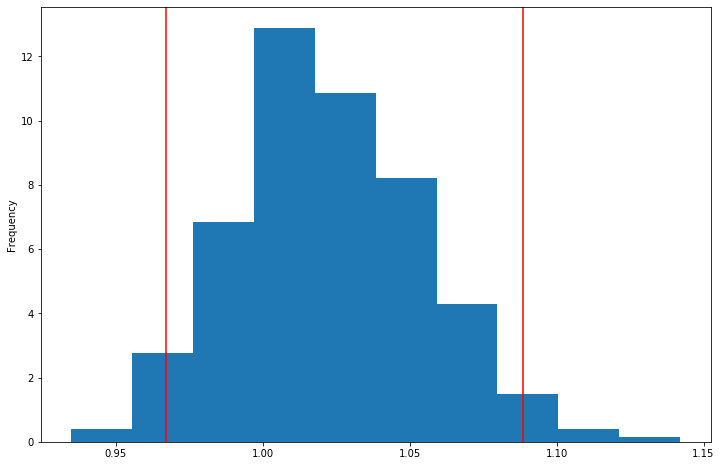

In [63]:
last_row_db = monte_carlo_cum_ret.iloc[-1,:]
confidence_interval = last_row_db.quantile(q=[0.025, 0.975])
plt.figure(figsize=(12,8));
last_row_db.plot(x = values, kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [64]:
confidence_interval

0.025    0.966967
0.975    1.088654
Name: 252, dtype: float64